In [1]:
import os 
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import spacy
import string
import nltk
from collections import Counter
from nltk.corpus import stopwords
from spacy.lang.en import English
from nltk.util import bigrams, trigrams
from itertools import chain

# Load the dictonary in English and Portuguese
spacy.load("en_core_web_sm")

# All stop works in German
stopwords = stopwords.words('english')

# Get the german language parser
parser = English()

# Define function to cleanup text by removing personal pronouns, stopwords, and puncuation
nlp = spacy.load("en_core_web_sm")
punctuations = string.punctuation


# Files
fileDir = os.path.dirname(os.path.realpath('__file__'))
filename = os.path.join(fileDir, 'data/rebirth-remains.csv')

# LÖoad file
df_raw_lyrics = pd.read_csv(filename,
                            index_col=False)
df_raw_lyrics.columns = ['index','artist','album','lyric']

# Backup to not use the Google API to get the language again
df = df_raw_lyrics

print (df_raw_lyrics.shape)

df_raw_lyrics.head(5)

(372, 4)


In [3]:
df.head(5)

,index,artist,album,lyric
0,0,sepultura,Bestial Devastation,"The curse is launched, beware\nThe Lord of Dea..."
1,1,sepultura,Bestial Devastation,A legion of demons\nBorn from boundaries of de...
2,2,sepultura,Bestial Devastation,Born from Hell\nThe supreme force of evil\nTo ...
3,3,sepultura,Bestial Devastation,The misfits high in this night\nCan feel the p...
4,4,sepultura,Bestial Devastation,Marching over the mist\nLeaving behind the wea...


In [4]:
df_raw_lyrics = df_raw_lyrics[pd.notnull(df_raw_lyrics['lyric'])]
df_raw_lyrics = df_raw_lyrics[~df_raw_lyrics["lyric"].str.contains("<span style=")]

In [37]:
df_raw_lyrics = df_raw_lyrics[~df_raw_lyrics["lyric"].str.contains("<span style=")]
df_raw_lyrics = df_raw_lyrics[~df_raw_lyrics["lyric"].str.contains("padding")]
df_raw_lyrics = df_raw_lyrics[~df_raw_lyrics["lyric"].str.contains("<img")]

(328, 5)

In [6]:
df_raw_lyrics.head(5)

,index,artist,album,lyric
0,0,sepultura,Bestial Devastation,"The curse is launched, beware\nThe Lord of Dea..."
1,1,sepultura,Bestial Devastation,A legion of demons\nBorn from boundaries of de...
2,2,sepultura,Bestial Devastation,Born from Hell\nThe supreme force of evil\nTo ...
3,3,sepultura,Bestial Devastation,The misfits high in this night\nCan feel the p...
4,4,sepultura,Bestial Devastation,Marching over the mist\nLeaving behind the wea...


In [8]:
def get_language(text):
    from textblob import TextBlob
    text = str(text)
    b = TextBlob(text)
    return b.detect_language()

In [9]:
df_raw_lyrics['lang'] = df_raw_lyrics['lyric'].apply(get_language)
df_raw_lyrics.groupby(['artist', 'lang']).size().reset_index()

,artist,lang,0
0,angra,en,119
1,angra,pt,4
2,sepultura,en,194
3,sepultura,ja,1
4,sepultura,pt,7


In [10]:
df_raw_lyrics = df_raw_lyrics[df_raw_lyrics['lang'] == 'en']

In [11]:
df_raw_lyrics.head(5)

,index,artist,album,lyric,lang
0,0,sepultura,Bestial Devastation,"The curse is launched, beware\nThe Lord of Dea...",en
1,1,sepultura,Bestial Devastation,A legion of demons\nBorn from boundaries of de...,en
2,2,sepultura,Bestial Devastation,Born from Hell\nThe supreme force of evil\nTo ...,en
3,3,sepultura,Bestial Devastation,The misfits high in this night\nCan feel the p...,en
4,4,sepultura,Bestial Devastation,Marching over the mist\nLeaving behind the wea...,en


In [12]:
df_raw_lyrics.groupby(['artist']).size().reset_index()

,artist,0
0,angra,119
1,sepultura,194


In [13]:
df_raw_lyrics.groupby(['artist', 'album']).size().reset_index()

,artist,album,0
0,angra,Angels Cry,9
1,angra,Aqua,10
2,angra,Aurora Consurgens,11
3,angra,Fireworks,11
4,angra,Freedom Call,8
5,angra,Holy Land,10
6,angra,Holy Live,4
7,angra,Hunters and Prey,7
8,angra,Omni,10
9,angra,Reaching Horizons,9


In [14]:
df_albuns = df_raw_lyrics.groupby(['artist', 'album']).size().reset_index()
df_albuns.columns = ['artist', 'album', 'qty_tracks']
df_albuns.groupby(['artist']).agg({'qty_tracks': [np.size, np.mean]}).reset_index()

artist qty_tracks           
                   size       mean
0      angra         13   9.153846
1  sepultura         18  10.777778

In [20]:
df_raw_lyrics['lyric'] = df_raw_lyrics['lyric'].astype(str)
df_raw_lyrics.head(10)

,index,artist,album,lyric
0,0,sepultura,Bestial Devastation,"The curse is launched, beware\nThe Lord of Dea..."
1,1,sepultura,Bestial Devastation,A legion of demons\nBorn from boundaries of de...
2,2,sepultura,Bestial Devastation,Born from Hell\nThe supreme force of evil\nTo ...
3,3,sepultura,Bestial Devastation,The misfits high in this night\nCan feel the p...
4,4,sepultura,Bestial Devastation,Marching over the mist\nLeaving behind the wea...
5,5,sepultura,Morbid Visions,Yeah\n\nThe Roman empire has crucified the mes...
6,6,sepultura,Morbid Visions,"Endless war, endless screams\nIn the boundarie..."
7,7,sepultura,Morbid Visions,Total eclipse hides the earth\nThe night of do...
8,8,sepultura,Morbid Visions,War!\n\nNuclear warheads cry out for destructi...
9,9,sepultura,Morbid Visions,We deny God's rule\nWe defy his supreme force\...


In [22]:
from nltk.corpus import stopwords
stop = stopwords.words('english')

df_raw_lyrics['lyric_2'] = df_raw_lyrics['lyric']

df_raw_lyrics['lyric_2'] = df_raw_lyrics['lyric_2'].apply(lambda x: ' '.join([item for item in x.split() if item not in stop]))


In [73]:
df_raw_lyrics.head(3)

,index,artist,album,lyric,lyric_2
0,0,sepultura,Bestial Devastation,"The curse launched, beware The Lord Death decl...","The curse launched, beware The Lord Death decl..."
1,1,sepultura,Bestial Devastation,A legion demons Born boundaries death Like ons...,A legion demons Born boundaries death Like ons...
2,2,sepultura,Bestial Devastation,Born Hell The supreme force evil To destroy al...,Born Hell The supreme force evil To destroy al...


In [72]:
df_raw_lyrics['lyric'] = df_raw_lyrics['lyric_2']

In [74]:
# Data exploration in some specific class to see the most frequent words
def get_word_frequency(artist):
    from nltk.corpus import stopwords
    stoplist = set(stopwords.words("english"))

    # Word Frequency per Category
    def cleanup_text(docs, logging=False):
        texts = []
        counter = 1
        for doc in docs:
            if counter % 1000 == 0 and logging:
                print("Processed %d out of %d documents." % (counter, len(docs)))
            counter += 1
            doc = nlp(doc, disable=['parser', 'ner'])
            tokens = [tok.lemma_.lower().strip() for tok in doc if tok.lemma_ != '-PRON-']
            tokens = [tok for tok in tokens if tok not in stoplist and tok not in punctuations]
            tokens = ' '.join(tokens)
            texts.append(tokens)
        return pd.Series(texts)

    df_text = [text for text in df_raw_lyrics[df_raw_lyrics['artist'] == artist]['lyric']]
    df_text_clean = cleanup_text(df_text)
    df_text_clean = ' '.join(df_text_clean).split()
    df_text_clean_counts = Counter(df_text_clean)
    df_common_words = [word[0] for word in df_text_clean_counts.most_common(21)]
    df_common_counts = [word[1] for word in df_text_clean_counts.most_common(21)]
    df_common_words.pop(0)
    df_common_counts.pop(0)

    fig = plt.figure(figsize=(18,6))
    sns.barplot(x=df_common_words, y=df_common_counts)
    plt.title(f'Most Common Words used in {artist} category')
    plt.xticks(rotation=45)
    plt.show()

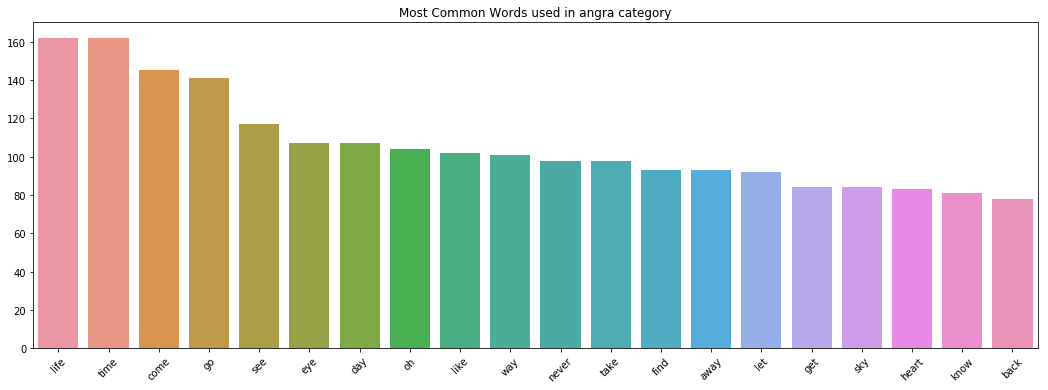

In [75]:
get_word_frequency('angra')

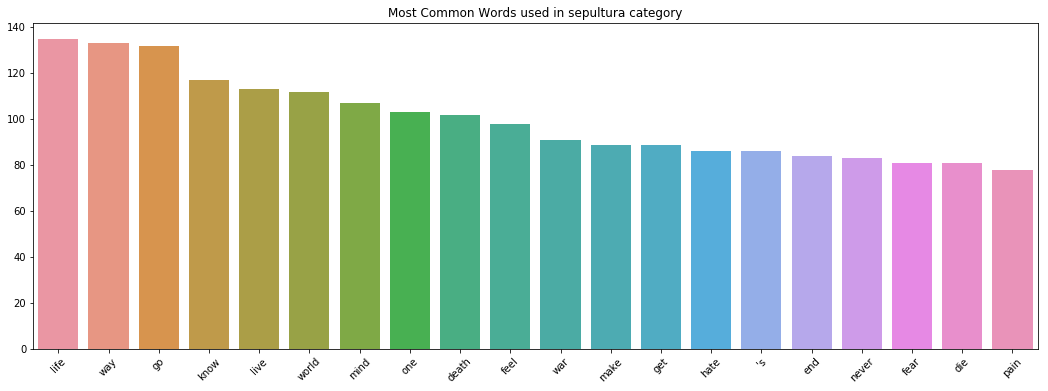

In [76]:
get_word_frequency('sepultura')

In [77]:
# Word cloud with most common words
most_common = pd.DataFrame(Counter(" ".join(df_raw_lyrics["lyric"]).split()).most_common(20))
most_common.columns = ['word','qty']

def show_wordcloud(text, artist):
    from PIL import Image
    from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
    
    from nltk.corpus import stopwords
    STOPLIST = set(stopwords.words('english'))

    # Create and generate a word cloud image:
    wordcloud = WordCloud(stopwords=STOPLIST, background_color="white").generate(text)

    # Display the generated image:
    fig = plt.figure(figsize=(25,10))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(f'Word Cloud for the {artist} category', fontsize=20)
    plt.axis("off")
    plt.show()
    
def get_wordcloud(df, artist):
    dataframe = df[df['artist'] == artist]
    # Get all texts and generate a cloud
    text = " ".join(review for review in dataframe.lyric)
    show_wordcloud(text, artist)    

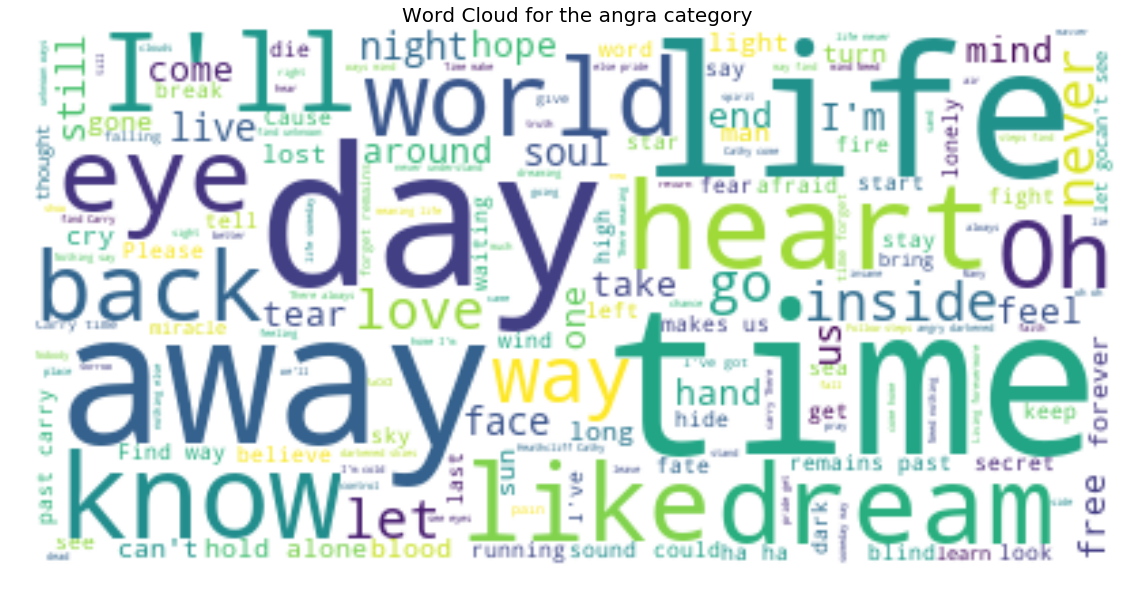

In [78]:
get_wordcloud(df_raw_lyrics, 'angra')

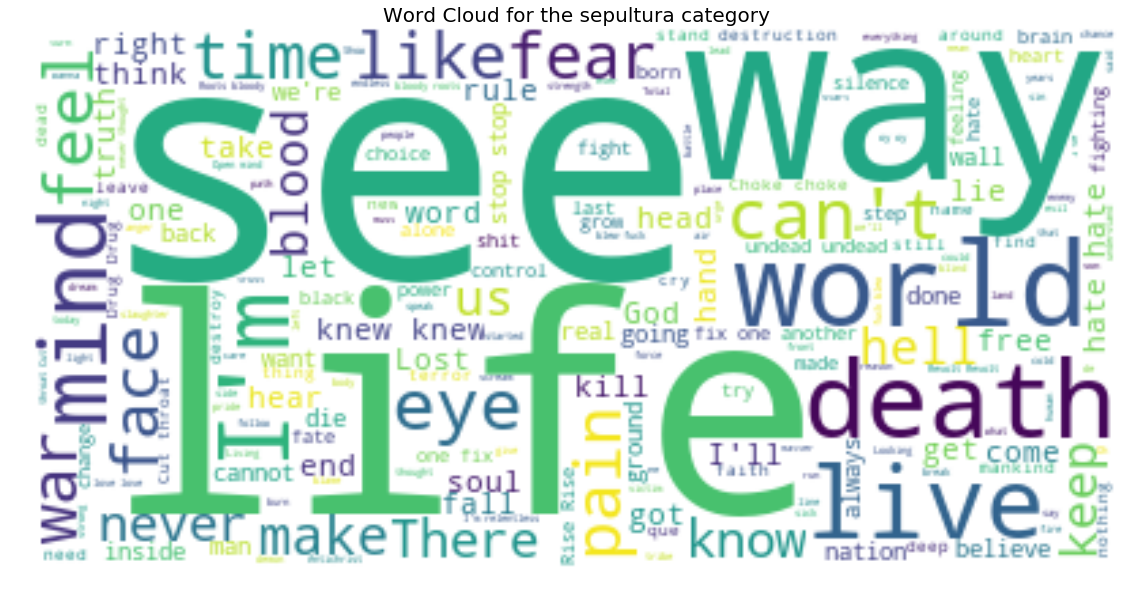

In [79]:
get_wordcloud(df_raw_lyrics, 'sepultura')

In [80]:
def get_lexical_diversity(df, artist):
    dataframe = df[df['artist'] == artist]

    full_text_count = pd.DataFrame(Counter(" ".join(dataframe["lyric"]).split()), index=[0])
    full_text_count = full_text_count.T
    full_text_count = full_text_count.reset_index()
    full_text_count.columns = ['word', 'qty']

    distinct_words = set()
    dataframe['lyric'].str.lower().str.split().apply(distinct_words.update)
    total_distinct_words = len(distinct_words)

    total_words = full_text_count['qty'].sum()

    lexical_diversity = round((total_distinct_words / total_words),2)

    print(artist, lexical_diversity)
    
    return artist, lexical_diversity

In [81]:
get_lexical_diversity(df_raw_lyrics, 'angra')

angra 0.19


('angra', 0.19)

In [82]:
get_lexical_diversity(df_raw_lyrics, 'sepultura')

sepultura 0.21


('sepultura', 0.21)

In [83]:
from sklearn.feature_extraction.text import CountVectorizer

def get_word_ngrams_list(df, artist, word_ngram):

    def get_top_word_n_bigram(corpus, n=None):
        vec = CountVectorizer(ngram_range=(word_ngram, word_ngram)).fit(corpus)
        bag_of_words = vec.transform(corpus)
        sum_words = bag_of_words.sum(axis=0) 
        words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
        words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
        return words_freq[:n]


    common_words = get_top_word_n_bigram(df[df['artist'] == artist]['lyric'], 20)
    df3 = pd.DataFrame(common_words, columns = ['desc' , 'count'])

    return df3

In [84]:
get_word_ngrams_list(df_raw_lyrics, 'angra', 2)

,desc,count
0,carry on,29
1,the remains,24
2,remains past,24
3,we re,24
4,ve got,23
5,ha ha,19
6,makes us,18
7,me cathy,18
8,you re,18
9,find way,18


In [85]:
get_word_ngrams_list(df_raw_lyrics, 'angra', 3)

,desc,count
0,the remains past,24
1,carry on time,16
2,on time forget,16
3,time forget the,16
4,forget the remains,16
5,remains past carry,16
6,angry darkened skies,16
7,heathcliff me cathy,16
8,me cathy come,16
9,cathy come home,16


In [86]:
get_word_ngrams_list(df_raw_lyrics, 'sepultura', 2)

,desc,count
0,we re,48
1,no no,48
2,knew don,28
3,stop me,27
4,undead undead,24
5,one fix,24
6,me stop,21
7,choke choke,21
8,hate you,20
9,you hate,20


In [87]:
get_word_ngrams_list(df_raw_lyrics, 'sepultura', 3)

,desc,count
0,no no no,35
1,undead undead undead,22
2,stop me stop,21
3,hate you hate,20
4,roots bloody roots,16
5,knew it knew,16
6,don that knew,16
7,cut throat cut,15
8,throat cut throat,15
9,just one fix,15


In [88]:
df_raw_lyrics_angra = df_raw_lyrics[df_raw_lyrics['artist'] == 'angra']
df_raw_lyrics_sepultura = df_raw_lyrics[df_raw_lyrics['artist'] == 'sepultura']

In [114]:
import re

# Convert to list
data = df_raw_lyrics_angra.lyric.values.tolist()

# Remove Emails
data = [re.sub('\S*@\S*\s?', '', sent) for sent in data]

# Remove new line characters
data = [re.sub('\s+', ' ', sent) for sent in data]

# Remove distracting single quotes
data = [re.sub("\'", "", sent) for sent in data]

In [115]:
vectorizer = CountVectorizer(analyzer='word',       
                             min_df=10,                        # minimum reqd occurences of a word 
                             stop_words='english',             # remove stop words
                             lowercase=True,                   # convert all words to lowercase
                             token_pattern='[a-zA-Z0-9]{3,}',  # num chars > 3
                             # max_features=50000,             # max number of uniq words
                            )

data_vectorized = vectorizer.fit_transform(data)

In [116]:
# Materialize the sparse data
data_dense = data_vectorized.todense()

# Compute Sparsicity = Percentage of Non-Zero cells
print("Sparsicity: ", ((data_dense > 0).sum()/data_dense.size)*100, "%")

Sparsicity:  14.928326914848094 %


In [117]:
# Build LDA Model
from sklearn.decomposition import LatentDirichletAllocation, TruncatedSVD

lda_model = LatentDirichletAllocation(n_topics=10,               # Number of topics
                                      max_iter=10,               # Max learning iterations
                                      learning_method='online',   
                                      random_state=100,          # Random state
                                      batch_size=128,            # n docs in each learning iter
                                      evaluate_every = -1,       # compute perplexity every n iters, default: Don't
                                      n_jobs = -1,               # Use all available CPUs
                                     )
lda_output = lda_model.fit_transform(data_vectorized)

print(lda_model)  # Model attributes

/Users/flavio.desouza/Documents/text-classification-spacy/text-classification-spacy/lib/python3.6/site-packages/sklearn/decomposition/online_lda.py:314: DeprecationWarning: n_topics has been renamed to n_components in version 0.19 and will be removed in 0.21
  DeprecationWarning)


LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
             evaluate_every=-1, learning_decay=0.7,
             learning_method='online', learning_offset=10.0,
             max_doc_update_iter=100, max_iter=10, mean_change_tol=0.001,
             n_components=10, n_jobs=-1, n_topics=10, perp_tol=0.1,
             random_state=100, topic_word_prior=None,
             total_samples=1000000.0, verbose=0)


In [118]:
# Helper function
def print_topics(model, count_vectorizer, n_top_words):
    words = count_vectorizer.get_feature_names()
    for topic_idx, topic in enumerate(model.components_):
        print("\nTopic #%d:" % topic_idx)
        print(" ".join([words[i]
                        for i in topic.argsort()[:-n_top_words - 1:-1]]))

In [119]:
# Print the topics found by the LDA model
print("Topics found via LDA:")
lda_model.fit(data_vectorized)

number_words = 10

print_topics(lda_model, vectorizer, number_words)

Topics found via LDA:


/Users/flavio.desouza/Documents/text-classification-spacy/text-classification-spacy/lib/python3.6/site-packages/sklearn/decomposition/online_lda.py:314: DeprecationWarning: n_topics has been renamed to n_components in version 0.19 and will be removed in 0.21
  DeprecationWarning)



Topic #0:
land ive say living got sky eyes deep long waiting

Topic #1:
come angels let life like light way try home lies

Topic #2:
light past freedom deep thunder air come ill dreams break

Topic #3:
hide hold life blind face answer world running better make

Topic #4:
time life eyes know past heart mind feel dont away

Topic #5:
day soul ive freedom believe dream pain far look start

Topic #6:
like life let world away way mind heart love face

Topic #7:
theres eyes face know like lives weve world away way

Topic #8:
soul wait fate silence fight face gone hear winds away

Topic #9:
day ill ive way left sky coming lives like say


In [131]:
# Create Document - Topic Matrix
lda_output = lda_model.transform(data_vectorized)

# column names
topicnames = ["Topic" + str(i) for i in range(lda_model.n_topics)]

# index names
docnames = ["Doc" + str(i) for i in range(len(data))]

# Make the pandas dataframe
df_document_topic = pd.DataFrame(np.round(lda_output, 2), columns=topicnames, index=docnames)

# Get dominant topic for each document
dominant_topic = np.argmax(df_document_topic.values, axis=1)
df_document_topic['dominant_topic'] = dominant_topic

# Styling
def color_green(val):
    color = 'green' if val > .1 else 'black'
    return 'color: {col}'.format(col=color)

def make_bold(val):
    weight = 700 if val > .1 else 400
    return 'font-weight: {weight}'.format(weight=weight)

# Apply Style
df_document_topics = df_document_topic.head(15).style.applymap(color_green).applymap(make_bold)
df_document_topics

,Topic0,Topic1,Topic2,Topic3,Topic4,Topic5,Topic6,Topic7,Topic8,Topic9,dominant_topic
Doc0,0,0,0,0,0.99,0,0,0,0,0,4
Doc1,0,0,0,0,0.99,0,0,0,0,0,4
Doc2,0,0.99,0,0,0,0,0,0,0,0,1
Doc3,0,0.98,0,0,0,0,0,0,0,0,1
Doc4,0,0,0,0,0,0,0.98,0,0,0,6
Doc5,0,0.98,0,0,0,0,0,0,0,0,1
Doc6,0,0,0,0,0.98,0,0,0,0,0,4
Doc7,0,0,0,0,0.35,0.64,0,0,0,0,5
Doc8,0.01,0.01,0.01,0.01,0.01,0.95,0.01,0.01,0.01,0.01,5
Doc9,0.98,0,0,0,0,0,0,0,0,0,0


In [132]:
df_topic_distribution = df_document_topic['dominant_topic'].value_counts().reset_index(name="Num Documents")
df_topic_distribution.columns = ['Topic Num', 'Num Documents']
df_topic_distribution

,Topic Num,Num Documents
0,4,40
1,6,20
2,1,17
3,5,11
4,0,10
5,7,8
6,2,7
7,9,5
8,3,3
9,8,2


In [133]:
pyLDAvis.enable_notebook()
panel = pyLDAvis.sklearn.prepare(lda_model, data_vectorized, vectorizer, mds='tsne')
panel

/Users/flavio.desouza/Documents/text-classification-spacy/text-classification-spacy/lib/python3.6/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=                x           y  topics  cluster       Freq
topic                                                    
4      -39.353210  -59.628372       1        1  28.822989
1      -86.117897   10.726873       2        1  18.602300
6      102.313972   41.338985       3        1  16.834793
5      104.257431 -111.267136       4        1   8.013193
0       51.060360  108.496490       5        1   6.746806
9      -41.305080   92.970917       6        1   6.220575
7       11.892313 -126.789978       7        1   5.770199
2      149.071548  -29.022879       8        1   3.806152
3        9.019955   22.366386       9        1   3.472301
8       53.938190  -40.658047      10        1   1.710692, topic_info=    Category        Freq      Term       Total  loglift  logprob
70   Default   36.000000      land   36.000000  30.0000  30.0000
119  Default   55.000000      soul   55.000000  29.0000  29.0000
67   Default   51.000000       ive   51.000000  28.0000  28.0000
135  Default  144.000000      time  144.000000  27.0000  27.0000
21   Default   83.000000       day   83.000000  26.0000  26.0000
130  Default   46.000000    theres   46.000000  25.0000  25.0000
33   Default   52.000000      face   52.000000  24.0000  24.0000
2    Default   58.000000    angels   58.000000  23.0000  23.0000
16   Default   76.000000      come   76.000000  22.0000  22.0000
59   Default   33.000000      hide   33.000000  21.0000  21.0000
32   Default  103.000000      eyes  103.000000  20.0000  20.0000
150  Default   70.000000     world   70.000000  19.0000  19.0000
109  Default   42.000000       say   42.000000  18.0000  18.0000
98   Default   45.000000      past   45.000000  17.0000  17.0000
76   Default   56.000000     light   56.000000  16.0000  16.0000
64   Default   61.000000       ill   61.000000  15.0000  15.0000
77   Default   95.000000      like   95.000000  14.0000  14.0000
4    Default   87.000000      away   87.000000  13.0000  13.0000
37   Default   21.000000      fate   21.000000  12.0000  12.0000
81   Default   27.000000    living   27.000000  11.0000  11.0000
116  Default   44.000000       sky   44.000000  10.0000  10.0000
142  Default   20.000000      wait   20.000000   9.0000   9.0000
61   Default   31.000000      hold   31.000000   8.0000   8.0000
24   Default   24.000000      deep   24.000000   7.0000   7.0000
69   Default   65.000000      know   65.000000   6.0000   6.0000
114  Default   16.000000   silence   16.000000   5.0000   5.0000
73   Default   83.000000       let   83.000000   4.0000   4.0000
48   Default   32.000000      gone   32.000000   3.0000   3.0000
29   Default   41.000000    dreams   41.000000   2.0000   2.0000
50   Default   34.000000       got   34.000000   1.0000   1.0000
..       ...         ...       ...         ...      ...      ...
147  Topic10    2.181779     winds   19.251310   1.8908  -3.6300
55   Topic10    2.183778      hear   23.047116   1.7118  -3.6291
111  Topic10    1.451598   secrets   16.108644   1.6616  -4.0375
133  Topic10    1.523786   thunder   17.505238   1.6270  -3.9890
48   Topic10    2.199373      gone   32.053208   1.3890  -3.6220
24   Topic10    1.534616      deep   24.207891   1.3099  -3.9819
122  Topic10    1.613653     stand   25.919694   1.2918  -3.9317
128  Topic10    1.555645     tears   25.119985   1.2865  -3.9683
136  Topic10    0.887691  tomorrow   14.525514   1.2732  -4.5293
119  Topic10    3.174412      soul   55.610468   1.2050  -3.2551
105  Topic10    1.489362     right   26.930005   1.1734  -4.0118
34   Topic10    1.539315      fall   29.246190   1.1239  -3.9788
33   Topic10    2.245690      face   52.498783   0.9165  -3.6012
42   Topic10    1.275606   forever   31.816454   0.8517  -4.1668
85   Topic10    0.912066      look   23.570422   0.8162  -4.5022
29   Topic10    1.543908    dreams   41.330612   0.7810  -3.9759
101  Topic10    0.878839     pride   27.807270   0.6138  -4.5393
118  Topic10    0.705170    sorrow   22.722708   0.5956  -4.7595
79   Topic1

In [135]:
# Topic-Keyword Matrix
df_topic_keywords = pd.DataFrame(lda_model.components_)

# Assign Column and Index
df_topic_keywords.columns = vectorizer.get_feature_names()
df_topic_keywords.index = topicnames

# View
df_topic_keywords.head()

,afraid,air,angels,answer,away,believe,better,blind,blood,break,...,wait,waiting,way,weve,wind,winds,wonder,words,world,years
Topic0,0.324471,0.470064,0.295957,0.286335,0.502735,0.283068,0.270440,0.294574,3.979808,1.135474,...,0.347417,6.813592,1.122641,0.262889,0.721628,2.652301,6.809162,0.267475,1.896379,1.875566
Topic1,0.276574,0.307363,41.277866,6.680463,15.203824,2.096675,4.309352,0.370008,0.272633,0.286674,...,0.568786,9.810296,17.914950,0.554201,2.631455,0.597561,1.176377,0.863694,2.484975,0.266105
Topic2,1.889333,3.809439,1.899845,0.266235,1.798676,0.246334,1.899254,1.097177,1.095633,3.476174,...,0.251157,0.296379,0.756561,0.294609,0.298863,1.086077,0.232086,1.085504,0.267128,1.059465
Topic3,0.289563,0.270174,2.214305,5.146285,0.230573,0.291121,4.312743,5.168572,0.259244,0.264741,...,1.052882,1.873005,0.489980,0.291452,1.059670,0.265499,0.281037,0.281283,4.827628,0.262722
Topic4,3.228842,0.659706,2.564399,1.879701,22.820754,7.270996,0.244197,3.207862,7.452562,5.097312,...,5.298671,3.911513,17.873192,3.811808,4.763238,5.550818,1.645966,4.931699,17.304971,1.430355


In [137]:
# Show top n keywords for each topic
def show_topics(vectorizer=vectorizer, lda_model=lda_model, n_words=20):
    keywords = np.array(vectorizer.get_feature_names())
    topic_keywords = []
    for topic_weights in lda_model.components_:
        top_keyword_locs = (-topic_weights).argsort()[:n_words]
        topic_keywords.append(keywords.take(top_keyword_locs))
    return topic_keywords

topic_keywords = show_topics(vectorizer=vectorizer, lda_model=lda_model, n_words=15)        

# Topic - Keywords Dataframe
df_topic_keywords = pd.DataFrame(topic_keywords)
df_topic_keywords.columns = ['Word '+str(i) for i in range(df_topic_keywords.shape[1])]
df_topic_keywords.index = ['Topic '+str(i) for i in range(df_topic_keywords.shape[0])]
df_topic_keywords


,Word 0,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9,Word 10,Word 11,Word 12,Word 13,Word 14
Topic 0,land,ive,say,living,got,sky,eyes,deep,long,waiting,wonder,like,place,someday,remains
Topic 1,come,angels,let,life,like,light,way,try,home,lies,skies,away,free,fly,cold
Topic 2,light,past,freedom,deep,thunder,air,come,ill,dreams,break,eyes,night,inside,left,right
Topic 3,hide,hold,life,blind,face,answer,world,running,better,make,sun,cause,dead,run,time
Topic 4,time,life,eyes,know,past,heart,mind,feel,dont,away,remains,inside,forget,live,theres
Topic 5,day,soul,ive,freedom,believe,dream,pain,far,look,start,words,just,end,eyes,stand
Topic 6,like,life,let,world,away,way,mind,heart,love,face,understand,soul,waiting,light,falling
Topic 7,theres,eyes,face,know,like,lives,weve,world,away,way,say,dreams,look,ill,reason
Topic 8,soul,wait,fate,silence,fight,face,gone,hear,winds,away,stand,world,tears,dreams,fall
Topic 9,day,ill,ive,way,left,sky,coming,lives,like,say,free,man,know,stay,till


In [123]:
from sklearn.feature_extraction.text import TfidfVectorizer

df_raw_lyrics_angra.set_index('album', inplace = True)
tf = TfidfVectorizer(analyzer='word', ngram_range=(1, 3), min_df=0, stop_words='english')
tfidf_matrix = tf.fit_transform(df_raw_lyrics_angra['lyric'])
cosine_similarities = linear_kernel(tfidf_matrix, tfidf_matrix)

indices = pd.Series(df_raw_lyrics_angra.index)

def recommendations(name, cosine_similarities = cosine_similarities):
    
    recommended_hotels = []
    
    # gettin the index of the hotel that matches the name
    idx = indices[indices == name].index[0]

    # creating a Series with the similarity scores in descending order
    score_series = pd.Series(cosine_similarities[idx]).sort_values(ascending = False)

    # getting the indexes of the 10 most similar hotels except itself
    top_10_indexes = list(score_series.iloc[1:11].index)
    
    # populating the list with the names of the top 10 matching hotels
    for i in top_10_indexes:
        recommended_hotels.append(list(df.index)[i])
        
    return recommended_hotels

KeyError: 'album'

In [ ]:
TODO
- Compare Sepultura Eras (Max - Derick)
- Compare Angra Eras (Mattos - Falaschi - Lioni)
- Similarity between Tracks (Content-based)